In [1]:
# ============================================================
# Notebook setup: run this before everything
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 5)

#from matplotlib import pyplot as plt
from util import util
#from scipy.integrate import odeint
import numpy as np
import pandas as pd
#from sklearn.metrics import r2_score
#from tensorflow import keras
#from skopt.space import Space
#from eml.net.reader import keras_reader

from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor

# Let's redo some work
f = lambda x: 1/(1+x) * np.sin(6 * np.pi * x) + x**2
x = np.linspace(0, 1, 10000)
target = pd.Series(index=x, data=f(x))

# Gaussian Processes

They check all the boxes

## Introduction to Gaussian Processes

**Gaussian Processes are a type of ML model**

...Capable of doing inference based on _set of observations_

* For input values close to those of known observations
* ...Their output can be close to those of the observations themselves

Finally, their output is a full _probability distribution_ (not a point estimate)

**Intuitively, they model a _conditional probability_**

$$
P(y \mid x, \hat{x}, \hat{y}) \simeq f(y, x, \hat{x}, \hat{y}, \omega)
$$

* The model is parameterized with a numeric vector, i.e. $\omega$
* ...But also with a set of examples with input $\hat{x}$ and output $\hat{y}$

They achieve this by relying on properties of the Normal (Gaussian) distribution

## Introduction to Gaussian Processes

**We will introduce the key concepts in GPs via an example:**

<center><img src="assets/rain1.png" width=450px/></center>

* Say we want to model how rainfall changes over a stretch of land
* $y =$ rainfall, $(x_0, x_1) =$ position on the surface of land 

## Introduction to Gaussian Processes

**We will introduce the key concepts in GPs via an example:**

<center><img src="assets/rain1.png" width=450px/></center>

Since this is a physical phenomenon...

* ...We can reasonably assume that $y$ is Normally distributed
* But unless we know more, we can say nothing else

## Introduction to Gaussian Processes

**We will introduce the key concepts in GPs via an example:**

<center><img src="assets/rain2.png" width=450px/></center>

However, if we have a few measurements...


* ...Then we can assume that _rainfall in nearby locations is similar_
* ...So we can infer rainfall for _positions for which we lack measurements_

## Introduction to Gaussian Processes

**We will introduce the key concepts in GPs via an example:**

<center><img src="assets/rain3.png" width=450px/></center>

E.g. we can view the measurements as components of a variable $y_X = (y_0, y_1, y_2)$

* $y_X$ will follow a _multivariate Normal distribution_
* ...And we can assume the covariance will depend on the distances

## Gaussian Processes, Formally

**Formally:**

A GP is a _stochastic process_, i.e. a collection of _indexed random variables_

* Each variable $y_{x}$ is indexed via a tuple $x$ (e.g. location, time...)
* The index is _continuous_ and the collection _infinite_
* Every finite subset of $y_{x}$ variables follows a _Multivariate Normal Distribution_

**Translating back to our original conditional probability:**

$$
P(y \mid x, \hat{x}, \hat{y}) \equiv P(y_x \mid \hat{y}_{\hat{x}})
$$

* $x$ is the GP input
* $y_x$ is the (stochastic) variable we want to estimate
* $\hat{x}$ is the input for all available observations
* ...And $\hat{y}_{\hat{x}}$ is the (stochastic) output

## Gaussian Processes, Formally

**A GP has access to:**

* The input vector $x$ for an unobserved point
* The input $\hat{x}_1, \hat{x}_2, \ldots$ for a number of observed points

Overall, let $\tilde{x} = (x, \hat{x}_1, \hat{x}_2, \ldots$

**We view the output $\tilde{y} = (y_x, \hat{y}_1, \hat{y}_2, \ldots)$ as a _Multivariate Normal Variable_**

$$
\tilde{y} \sim \mathcal{N}(\mu, \Sigma)
$$

With the aim to define the distribution, we make _two assumptions_:

* $\mu = 0$ (we can satisfy this by centering the data)
* The covariance matrix depends on the set of inputs...
* ...And on the the $\omega$ parameter vector, i.e. $\Sigma(\tilde{x}, \omega)$

## Gaussian Processes, Formally

**This is _enough_ to estimate the distribution we need**

The PDF for multivariate normal distribution is available in _closed form_

$$
\phi(x, \mu, \Sigma) = \det(2\pi \Sigma)^{-\frac{1}{2}} e^{(x - \mu)^T \Sigma^{-1} (x - \mu)}
$$

* Therefore, for our $y$ variable we have:

$$
P(y | \hat{y}) = \frac{\phi(\tilde{y}, 0, \Sigma(\tilde{x}, \omega))}{\phi(\hat{y}, 0, \Sigma(\hat{x}, \omega))}
$$

* Which implies we can also easily get the PDF for $\hat{y}_{\hat{x}}$
* In fact, we can do it for every finite subset of observations

The catch is that we need to _define how to compute $\Sigma(x, \omega)$_


## Gaussian Processes, Formally

**We build $\Sigma$ by means of a user-defined _kernel function $K$_**

Given a set of (random) variables $y = (y_{x_1}, y_{x_2}, \ldots)$, we have:

$$
\Sigma_{ij}(x, \omega) = K(x_i, x_j, \omega)
$$

* Where the $x_i, x_j$ are the input for the considered pair
* ...And $\omega$ is a (kernel-dependent) parameter vector

The overall covariance matrix will be structured as:

$$\Sigma(x, \omega) = \left(\begin{array}{cccc}
K(x_1, x_1, \omega) & K(x_1, x_2, \omega) & \cdots & K(x_1, x_n, \omega) \\
K(x_2, x_1, \omega) & K(x_2, x_2, \omega) & \cdots & K(x_2, x_n, \omega) \\
\vdots & \vdots & \vdots & \vdots \\
K(x_n, x_1, \omega) & K(x_n, x_2, \omega) & \cdots & K(x_n, x_n, \omega) \\
\end{array}\right)$$

## Training a Gaussian Process

**In practice, to setup a GP model we**

* Collect _training observations_ $\hat{y}_\hat{x}$
* Pick a _parameterized_ kernel function $K(x_i, x_j, \omega)$

Then we choose $\omega$ by maximizing the _likelihood_ of the training data:

$$
\text{argmax}_\omega \phi(\hat{y}, 0, \Sigma(\hat{x}, \omega))
$$

* After this is done, we can _store the training observations_
* ...And use the to condition our predictions

**The training problem**

* Is a (possibly challenging) numerical optimization problem
* ...Which is typically solved to _local optimality_ (e.g. via gradient descent)

# Gaussian Processes in Practice

This is When It will all make sense... Hopefully

## Target and Training Set

**Let's see how to use GPs in scikit-learn**

First, we need to collect a training setusing our example function and some noise

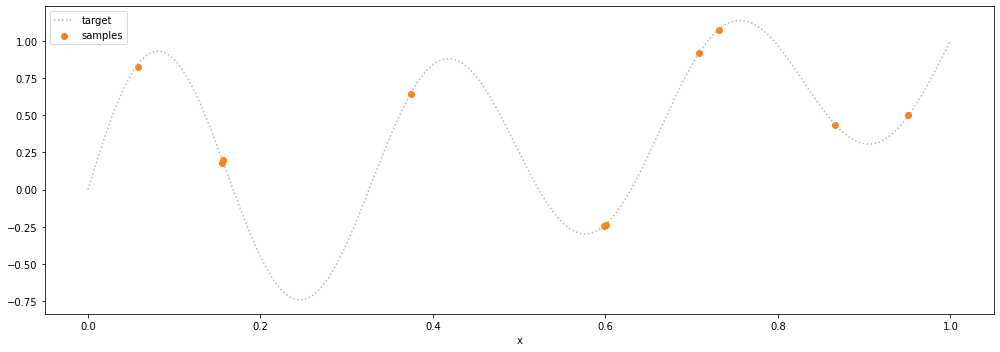

In [2]:
np.random.seed(42)
x_tr = np.random.rand(10)
y_tr = pd.Series(index=x_tr, data=f(x_tr) + 0.01*np.random.randn(10))
util.plot_series(samples=y_tr, target=target, figsize=figsize, xlabel='x')

## Radial Basis Functions

**Next we need to pick a kernel function**

* There are [many available options](https://scikit-learn.org/stable/modules/gaussian_process.html)
* ...But we will focus on those typically used in Bayesian Optimization

**We will _start_ with a _Radial Basis Function_ kernel**

This is in the form:

$$
K(x_i, x_j, \omega) = e^{-\frac{d(x_i, x_j)^2}{2l}}
$$

The correlation _decreases with the (Euclidean) distance_ $d(x_i, x_j)$:

* Intuitively, the closer the points, the higher the correlation
* The $l$ parameter (_scale_) control the rate of the reduction

The $\omega$ vector will just be the collection of all kernel parameters

## Untrained Guassian Processes

**Let's start by building an RBF kernel with default parameters**

In [3]:
kernel = RBF()
kernel

RBF(length_scale=1)

Then we build a GP regressor and obtain our predictions

In [4]:
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=True)
y_mu, y_std = gp.predict(x.reshape(-1,1), return_std=True)

The "predictions" in this case are full probability distribution

* Since we know they are Normal
* ...They are characterized via a mean and standard deviation

## Untrained Guassian Processes

**Here's how the prediction look _before training_**

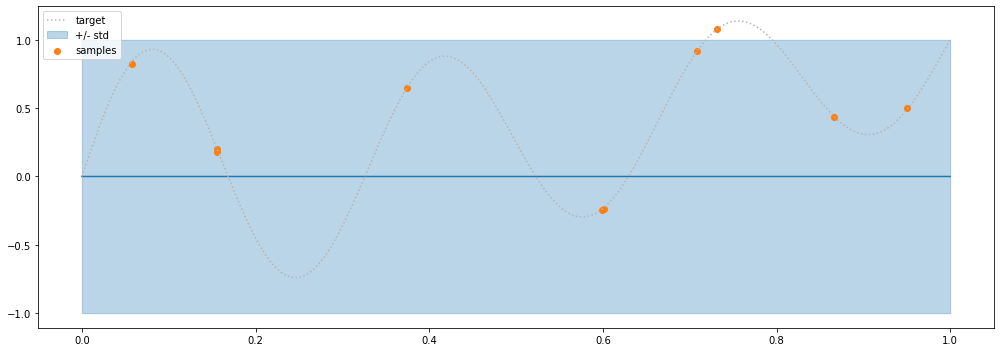

In [5]:
y_mu, y_std = pd.Series(index=x, data=y_mu), pd.Series(index=x, data=y_std)
util.plot_series(series=y_mu, std=y_std, samples=y_tr, target=target, figsize=figsize)

* The mean is 0 everywhere
* ...And we are not exploiting $\Sigma$, since there is _no stored observarion_

## Training a Gaussian Process

**Now, let's train our model:**

In [6]:
gp.fit(y_tr.index.values.reshape(-1,1), y_tr.values)

GaussianProcessRegressor(kernel=RBF(length_scale=1), n_restarts_optimizer=9,
                         normalize_y=True)

During this process, two things happen:

* First, the kernel parameters are optimized
* Second, the training observations are _stored in the model_

In [7]:
print(gp.kernel_)
print('X_train_:', str(gp.X_train_).replace('\n', ','))
print('y_train_:', str(gp.y_train_).replace('\n', ','))

RBF(length_scale=0.000494)
X_train_: [[0.37454012], [0.95071431], [0.73199394], [0.59865848], [0.15601864], [0.15599452], [0.05808361], [0.86617615], [0.60111501], [0.70807258]]
y_train_: [ 0.49936961  0.16078846  1.49069525 -1.55533978 -0.52939824 -0.57819753,  0.91577366  0.01106198 -1.5385743   1.12382089]


## Not Yet There

**Let's check the updated predictions**

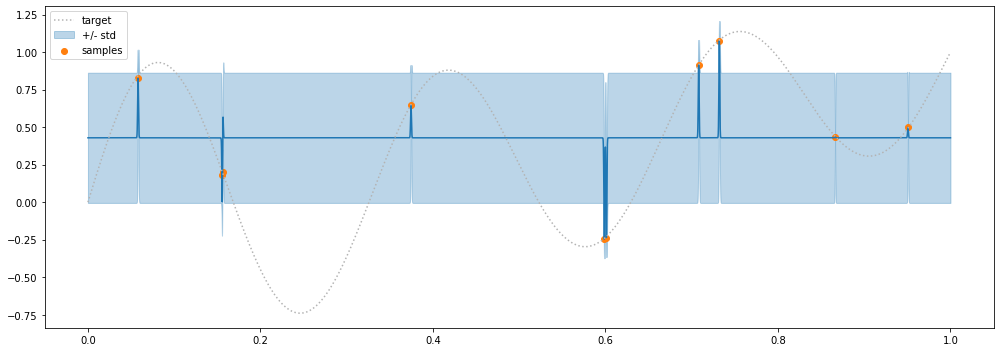

In [8]:
y_mu, y_std = gp.predict(x.reshape(-1,1), return_std=True)
y_mu, y_std = pd.Series(index=x, data=y_mu), pd.Series(index=x, data=y_std)
util.plot_series(series=y_mu, std=y_std, samples=y_tr, target=target, figsize=figsize)

* The predicted means are close to all the observations (good news)
* ...But they get far from them very quickly (bad news)

## White Noise

**The issue is that we never told our model there is noise in the data**

This can be done by adding a _while noise_ kernel:

$$
K(x_i, x_j, \omega) = e^{-\frac{d(x_i, x_j)^2}{2l}} + \nu(i, j)
$$

Where:

$$
\nu(i,j) = \left\{\begin{align} & \sigma^2 & \text{if $i = j$} \\
& 0 & \text{otherwise}
\end{align}\right.
$$

* $\sigma$ is the only kernel parameter
* We are telling the GP that observations have some _intrinsic variance_
* ...Freeing it from the need to _interpolate exactly_ all observations

## A Decent, Trained, Gaussian Process

**Let's repeat training and display the results**

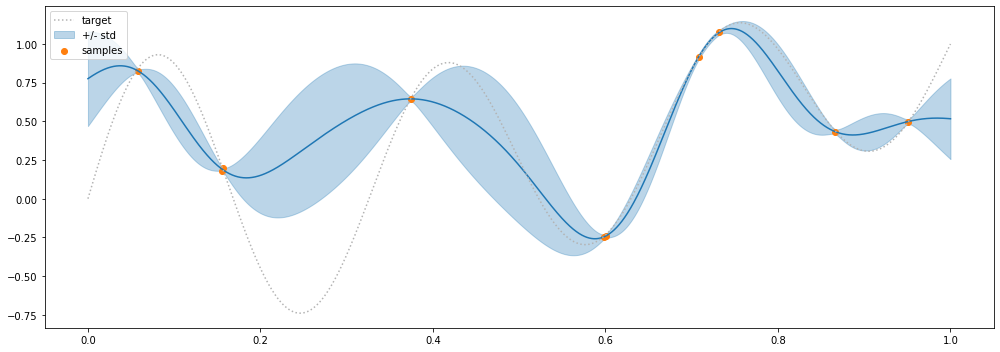

In [9]:
y_mu, y_std = util.univariate_gp_tt(RBF()+WhiteKernel(), x_tr, y_tr, x)
util.plot_series(series=y_mu, std=y_std, samples=y_tr, target=target, figsize=figsize)

* All the predicted means are close to the observed ones
* ...And we get meaningful confidence intervals elsewhere